In [2]:
import numpy as np
from numpy import sin,cos,pi,exp
from numpy.linalg import norm
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core import Lattice, Structure
import matplotlib.pyplot as plt
from pymatgen.vis.structure_vtk import StructureVis
from IPython.display import display
%matplotlib widget

def lattice_parameters_cartesian(structure):
    ABC = structure.lattice.__dict__["_matrix"]
    return ABC[0], ABC[1], ABC[2]

def electric_field(r,lattice_point_dict,charge_dict): # r is the position vector where you want to know the total field
    """
    Finds and returns the electric field at a specified point based on the lattice points
    
    r - the position vector where you want to know the total field
    lattice_point_dict - must be a dictionary - if generated from a structure use to_dict function
    charge_dict - must name each atom present, and it's ionic charge
    """
    field = np.array((0, 0, 0))
    
    for element in lattice_point_dict.keys():
        # if element == 'O':
        #     pass
        # else:
        for R in lattice_point_dict[element]:  # R is a position vector for the ion producing the field
            d = r - R
            if norm(d) < 0.1:
                pass
            else:
                field = field + charge_dict[element]*d/(norm(d)**3)
    return field


def electric_field_dict(r,lattice_point_dict,charge_dict): # electric_field, but returns dict of elements w/ fields instead
    
    field = {}
    for element in lattice_point_dict.keys():
        field[element] = []
        # if element == 'O':
        #     pass
        # else:
        for R in lattice_point_dict[element]:  # R is a position vector for the ion producing the field
            d = r - R
            if norm(d) < 0.1:
                pass
            else:
                field[element].append(charge_dict[element]*d/(norm(d)**3)*5)
    return field

def electric_field_oxygen(r,lattice_point_dict,charge_dict): # Electric Field based on only the oxide ions
    field = np.array((0, 0, 0))
    for R in lattice_point_dict['O']:  # R is a position vector for the ion producing the field
        d = r - R
        if norm(d) < 1:
            pass
        else:
            field = field + charge_dict['O']*d/(norm(d)**3)
    return field

def to_dict(struct): # changes structure to the kind of dict suitable for Electric Field
    PMG_struct_dict = struct.as_dict()
    struct_dict = {}
    for atom in PMG_struct_dict['sites']:
        atom_name = atom['species'][0]['element']
        try:
            struct_dict[atom_name].append(np.array(atom['xyz']))
        except:
            struct_dict[atom_name] = [np.array(atom['xyz'])]
    return struct_dict

def visualize_struct(struct, field_strength=[], ind=0, relative_vectors=[]):
    """
    Visualizes structure in seporate window - have to close window to continue running other code
    
    struct - pymatgen Structure
    field_strength - list of strengths of fields that will appear as lines in the image
    ind - the index of the atom in struct that you want the lines to be based on
    relative_vectors - adds lines that start at the terminal points of the field_strenth lines
    """
    vis = StructureVis(element_color_mapping={'Eu': (0, 255,200), 'O':(255,0,0), 'Y':(100, 100, 255), 'Si':(255, 255, 50)})
    # Eu3+ : Cyan, O2- : Red, Y3+ : blue, Si4+ : Yellow 
    vis.show_polyhedron = False
    vis.poly_radii_tol_factor -= 0.25
    vis.set_structure(struct.copy())
    if type(field_strength) == dict:
        e_color = {'O':(225,0,0), 'Y':(0,0,255),  'Si':(0,255,0), 'Eu':(200,255, 0), 'Be':(0,0,0)}
        for element in field_strength.keys():
            for i in range(len(field_strength[element])):
                vis.add_line(struct.cart_coords[ind], struct.cart_coords[ind] + field_strength[element][i]*5, e_color[element], width=10)
    else:
        for i in range(len(field_strength)):
            vis.add_line(struct.cart_coords[ind], struct.cart_coords[ind] + field_strength[i], (0, 255, 0), width=10)
            for j in range(len(relative_vectors)):
                vis.add_line(struct.cart_coords[ind] + field_strength[i], struct.cart_coords[ind] + field_strength[i] + relative_vectors[j], (225, 0, 0), width=10)
    display(vis.show())

In [3]:
def find_bonds(atom_index, struct, remove_self=False, visual=False):
    """
    finds the atoms (OXYGENS) bonded to a specific site, and returns a Structure containing with only the ion and its neighbors
    """
    num_atoms = len(struct)
    filled_struct = struct.copy().make_supercell(3,3,3)
    atom_index = 27*atom_index + 13
    bonded_atoms = [] if remove_self else [filled_struct[atom_index]]
    atom_symbol = filled_struct[atom_index].specie.symbol
    for i in range(len(filled_struct)):
        crystal_atom_symbol = filled_struct[i].specie.symbol
        if crystal_atom_symbol == "O": #True
            max_d = 3 #CovalentRadius.radius[atom_symbol] + CovalentRadius.radius[crystal_atom_symbol] + 0.2 # 0.2 bond tolerance
            d = filled_struct.get_distance(atom_index, i, np.array([0, 0, 0]))
            if d < max_d:
                bonded_atoms.append(filled_struct[i])
    output = Structure.from_sites(bonded_atoms)
    if visual:
        visualize_struct(output)
    return output

In [4]:
structure = Structure.from_file("/home/icarus/Downloads/Y2SiO5_mp-554420_conventional_standard.cif").to_conventional().sort() #"C:\\Users\\Tosin\\Desktop\\Y2SiO5.cif").sort()

# setting the perameters to what they apear to be from the code
a = np.array([cos((90-102.6136)*np.pi/180),sin((90-102.6136)*np.pi/180),0])*10.39605
b = np.array([0,0,1])*6.71397
c = np.array([0,1,0])*12.4723
D1 = np.array([cos((90+11.35)*np.pi/180),sin((90+11.35)*np.pi/180),0])*10.39605
D2 = np.array([cos((11.35)*np.pi/180),sin((11.35)*np.pi/180),0])*10.39605
structure._lattice = Lattice([a, b, c])
crystal = structure.copy().sort()

lattice_points = {'Y': [], 'Si': [], 'O': []}
for i in range(len(crystal)):
       name = crystal[i].species_string
       lattice_points[name].append(crystal.cart_coords[i]) 

In [5]:
charges = {'Y': 3, 'Si': 4, 'O': -2, 'Eu': 3}
K = 8.99*10**9 * (1.6*10**(-19)) / 10**(-20)     # K = (1/4 pi epsilon_0) * e / (1 angstrom)**2  
K_gig = K*10**(-9) # Giga K units
cell_vector_struct = structure.copy().append("Li", np.array([1,0,0])).append("Li", np.array([0,1,0])).append("Li", np.array([0,0,1]))
a,b,c = cell_vector_struct.cart_coords[-3:]
print(K)
print(lattice_parameters_cartesian(structure))
print(norm(a),norm(b),norm(c))

143840000000.00003
(array([10.14514086, -2.27023621,  0.        ]), array([0.     , 0.     , 6.71397]), array([ 0.    , 12.4723,  0.    ]))
10.39605 6.71397 12.4723


In [6]:
field_at_pts = []
for i in range(16):
    point_field = electric_field(find_bonds(i, crystal)[0].coords, to_dict(find_bonds(i, crystal)), charges)
    b_proj = np.dot(b, point_field)/(norm(point_field)*norm(b))*b
    ac_proj = point_field-b_proj
    D2_proj =  np.dot(D2, ac_proj)/(norm(ac_proj)*norm(D2))*D2
    print(f"{norm(point_field)*K:.3e}   \
    φ = {np.arccos(norm(b_proj)/norm(b))*180/np.pi:.3e}   \
    θ = {np.arccos(norm(D2_proj)/norm(D2))*180/np.pi:.3e} ")
    # θ, φ are the angles between the plane and the b and D2 axes respectively 
    field_at_pts.append(point_field*K_gig)

2.258e+10       φ = 4.721e+01       θ = 8.854e+01 
2.258e+10       φ = 4.721e+01       θ = 8.854e+01 
2.258e+10       φ = 4.721e+01       θ = 8.854e+01 
2.258e+10       φ = 4.721e+01       θ = 8.854e+01 
1.136e+10       φ = 8.891e+01       θ = 8.509e+01 
1.136e+10       φ = 8.891e+01       θ = 8.509e+01 
1.136e+10       φ = 8.891e+01       θ = 8.509e+01 
1.136e+10       φ = 8.891e+01       θ = 8.509e+01 
3.856e+10       φ = 5.552e+01       θ = 8.912e+01 
3.856e+10       φ = 5.552e+01       θ = 8.912e+01 
3.856e+10       φ = 5.552e+01       θ = 8.912e+01 
3.856e+10       φ = 5.552e+01       θ = 8.912e+01 
0.000e+00       φ = nan       θ = nan 
0.000e+00       φ = nan       θ = nan 
0.000e+00       φ = nan       θ = nan 
0.000e+00       φ = nan       θ = nan 


/tmp/ipykernel_842661/2660782043.py:4: RuntimeWarning: invalid value encountered in scalar divide
  b_proj = np.dot(b, point_field)/(norm(point_field)*norm(b))*b


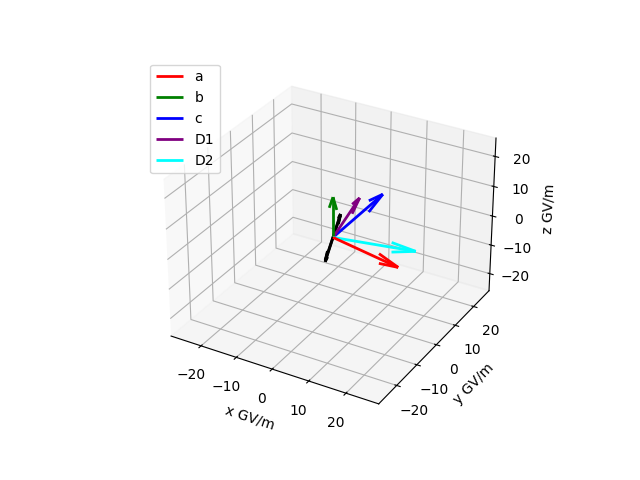

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
point_size=100

ax.set_xlabel("x GV/m")
ax.set_ylabel("y GV/m")
ax.set_zlabel("z GV/m")

scale = 25  # creates a box of this size so that all of the plot is shown
for l in range(2):
    for n in range(2):
        for p in range(2):
            plt.plot((l*2-1)*scale, (n*2-1)*scale, (p*2-1)*scale)
fcolors = {"dip" :'g', "mono": 'r', "d+m":'b'}

vect_pos = np.array([0,0,0])
for i in range(4,8): 
    ax.quiver(*vect_pos, *(vect_pos + (field_at_pts[i])) , lw=2, color='k')
for i in range(12,16):
    ax.quiver(*vect_pos, *(vect_pos + (field_at_pts[i])) , lw=2, color='k')

ax.quiver(*vect_pos, *a*2 , lw=2, color= 'r', label='a')
ax.quiver(*vect_pos, *b*2 , lw=2, color= 'g', label='b' )
ax.quiver(*vect_pos, *c*2 , lw=2, color= 'b', label='c')
ax.quiver(*vect_pos, *D1*2 , lw=2, color= 'purple', label='D1')
ax.quiver(*vect_pos, *D2*2 , lw=2, color= 'cyan', label='D2')
plt.legend()
plt.show()

In [8]:
from pymatgen.core.periodic_table import Species
from pymatgen.core.sites import Site
# A crystal created just for the sake of visualization
vis_crystal = crystal.copy()

# relpacing ions at site 1 to show visual difference
for i in range(4):
    vis_crystal.replace(i, Species('Eu3+'))
for i in range(4):
    vis_crystal.replace(i+8, Species('Eu3+'))

In [10]:
# Visualizing the crystal
visualize_struct(vis_crystal.copy())

None

In [ ]:
crystal.